
# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第12节 机器学习与比特币示例</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

在《量化交易之路》中我曾经编写过猪老三的世界中使用机器学习对股价和涨跌进行预测的幻想示例。

![](./image/pig3.png)

在猪老三的世界中实现了：**机器学习.fit(x, y) ＝ (股价预测，涨跌预测) ＝发财**

在猪老三的童话中我设定的可以影响股价走势的参数是有限个的，特别是影响涨跌的因素很容易构造特征。在真实的市场中可以影响股价走势的因素是无限多的，而且这些因素之间的也可以是相关的。就像你求解一个方程组，这个方程组不是有一个两个解，它是有无限个解的系统，并且每个解都与其他任意个解相关，但又并非简单线性相关。市场是一个二级混沌系统，认为任何想通过技术对股价进行预测或者涨跌预测都是不可能的，不伦你自己认为你使用的技术本身有多高深，无异于管中窥豹。

本系列教程中讲到的ump裁判系统是abupy中通过机器学习技术对回测结果进行学习，反向指导决策新的交易是否拦截的实际应用，本节讲解机器学习在量化领域很有作用的另一个方向：阀值的估计，因为无论是编写选股策略，择时策略还是任何涉及决策的代码模型中都离不开阀值，比如最常用的止盈止损策略，在代码的编写中就一定会涉及阀值，比如之前的章节一直使用的abupy中内置止盈止损策略AbuFactorCloseAtrNStop。

之所以一定会涉及阀值的确定是因为就像刚刚说的类似你求解一个方程组，如果所有的参数都是未知数，那么你怎么解出你需要的答案，所以一定要把一些变量变成常数值，然后通过这些常数值来确定更多的变量，最终解出你所关心的解。

对于阀值的确定传统的做法是根据经验来设定，实际上所谓的经验是个体对问题的统计模型， 在机器学习技术的帮助下，可以实现更客观，全面，适应范围更广的阀值设定。

不论是个体经验对阀值进行常量定估还是通过机器学习技术通过数据模型对阀值进行定估，都达不到绝对准确预测结果的目标，量化交易的概率优势并不具有绝对的优势，即达不到预测的程度，量化交易中大多策略是基于对历史规律的总结，在规律的基础上发现概率优势，它的最大理论依据是人性的相似性以及人性很难改变的事实，如果每一个瞬间的股票价格都是全体交易者对价值所达成的一种瞬间共识，那么历史的规律在今后的交易中同样具有指导意义。

按照上面解方程的说法就是，定估的常量只要能满足大多数时候解出合理的解，甚至很多时候定估的常量只要能满足有时候能解出合理的解就可以，对于有时候能解出合理的情况，可以在上层通过非均衡技术对决策进行二次逻辑过滤，我反复提及过的非均衡技术思想是量化中很很重要的一种设计思路，因为我们量化的目标结果就是非均衡，**我们想要赢的钱比输的多**。

首先导入本节需要的模块

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


### 1. 比特币特征的提取

下面通过对比特币的短线交易决策为例，示例上述论点以及abupy中机器学习模块的使用，以及数据获取：

In [2]:
from abupy import abu, ml, nd, tl, pd_resample, AbuML, AbuMLPd, AbuMetricsBase 
from abupy import ABuSymbolPd, ABuScalerUtil, get_price, ABuMarketDrawing, ABuKLUtil

# btc是比特币symbol代号
btc = ABuSymbolPd.make_kl_df('btc', start='2013-09-01', end='2017-07-26')

之前在比特币, 莱特币的回测那节使用ABuKLUtil.date_week_wave对走势的日震荡做过统计如下：

In [3]:
ABuKLUtil.date_week_wave(btc)

date_week
周一    5.0108
周二    5.5610
周三    5.4437
周四    5.7275
周五    5.3008
周六    4.7875
周日    4.6528
Name: wave, dtype: float64

从上面可以看出大概0.055的日震荡幅度可以成做大波动的交易对比特币来说，下面对数据添加新列big_wave，可以看到结果大波动的占总交易日的1/3：

In [4]:
btc['big_wave'] = (btc.high - btc.low) / btc.pre_close > 0.055
btc['big_wave'] = btc['big_wave'].astype(int)
btc['big_wave'].value_counts()

0    1005
1     420
Name: big_wave, dtype: int64

任何大的决策其实都是由很多看极起来极不起眼的小事组成的，如果我们是做比特币日内的交易者，首先你需要判断今天适不适合做交易，做出这个判断的依据里有一条即是今天的波动需要足够大，下面通过机器学习技术演示如何决策今天的波动是否足够大。

备注：由于abupy中内置沙盒数据没有分时的数据，所以本示例使用日线数据做为分析对象，实际策略中应该使用的是分钟数据

首先切割训练集和测试集，保留最后60天走势数据做为测试集数据：

In [5]:
btc_train_raw = btc[:-60]
btc_test_raw = btc[-60:]

下面为训练集和测试集数据都加上5，10，21，60日均线特征：

In [6]:
def calc_ma(tc, ma):
    ma_key = 'ma{}'.format(ma)
    tc[ma_key] = nd.ma.calc_ma_from_prices(tc.close, ma, min_periods=1)
for ma in [5, 10, 21, 60]:
    calc_ma(btc_train_raw, ma)
    calc_ma(btc_test_raw, ma)
btc_train_raw.tail(1)

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,big_wave,ma5,ma10,ma21,ma60
2017-05-27,15799.99,13530.03,15999.0,12355.0,28263,20170527,15749.08,5,-14.09,1364,2289.4437,2819.2068,1,15836.082,14293.794,11937.3952,8994.2298


编写特征抽取组合函数btc_siblings_df：

* 它首先将所有交易日以3个为一组，切割成多个子df，即每一个子df中有3个交易日的交易数据
* 使用数据标准化将连续3天交易日中的连续数值特征进行标准化操作
* 抽取第一天，第二天的大多数特征分别改名字以one，two为特征前缀，如：one_open，one_close，two_ma5，two_high....., 
* 第三天的特征只使用'open', 'low', 'pre_close', 'date_week'，该名前缀today，如today_open，today_date_week
* 第三天的抽取了'big_wave'，其将在之后做为y
* 将抽取改名字后的特征连接起来组合成为一条新数据，即3天的交易数据特征－>1条新的数据

代码如下所示：

In [7]:
def btc_siblings_df(btc_raw):
    # 将所有交易日以3个为一组，切割成多个子df，即每一个子df中有3个交易日的交易数据
    btc_siblings = [btc_raw.iloc[sib_ind * 3:(sib_ind + 1) * 3, :]
                    for sib_ind in np.arange(0, int(btc_raw.shape[0] / 3))]

    btc_df = pd.DataFrame()
    for sib_btc in btc_siblings:
        # 使用数据标准化将连续3天交易日中的连续数值特征进行标准化操作
        sib_btc_scale = ABuScalerUtil.scaler_std(
            sib_btc.filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                            'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14']))
        # 把标准化后的和big_wave，date_week连接起来
        sib_btc_scale = pd.concat([sib_btc['big_wave'], sib_btc_scale, sib_btc['date_week']], axis=1)

        # 抽取第一天，第二天的大多数特征分别改名字以one，two为特征前缀，如：one_open，one_close，two_ma5，two_high.....
        a0 = sib_btc_scale.iloc[0].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a0.rename(index={'open': 'one_open', 'close': 'one_close', 'high': 'one_high', 'low': 'one_low',
                         'volume': 'one_volume', 'pre_close': 'one_pre_close',
                         'ma5': 'one_ma5', 'ma10': 'one_ma10', 'ma21': 'one_ma21',
                         'ma60': 'one_ma60', 'atr21': 'one_atr21', 'atr14': 'one_atr14',
                         'date_week': 'one_date_week'}, inplace=True)

        a1 = sib_btc_scale.iloc[1].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a1.rename(index={'open': 'two_open', 'close': 'two_close', 'high': 'two_high', 'low': 'two_low',
                         'volume': 'two_volume', 'pre_close': 'two_pre_close',
                         'ma5': 'two_ma5', 'ma10': 'two_ma10', 'ma21': 'two_ma21',
                         'ma60': 'two_ma60', 'atr21': 'two_atr21', 'atr14': 'two_atr14',
                         'date_week': 'two_date_week'}, inplace=True)
        # 第三天的特征只使用'open', 'low', 'pre_close', 'date_week'，该名前缀today，如today_open，today_date_week
        a2 = sib_btc_scale.iloc[2].filter(['big_wave', 'open', 'low', 'pre_close', 'date_week'])
        a2.rename(index={'open': 'today_open', 'low': 'today_low',
                         'pre_close': 'today_pre_close',
                         'date_week': 'today_date_week'}, inplace=True)
        # 将抽取改名字后的特征连接起来组合成为一条新数据，即3天的交易数据特征－>1条新的数据
        btc_df = btc_df.append(pd.concat([a0, a1, a2], axis=0), ignore_index=True)
    return btc_df

第三天的特征避免使用high是因为训练的目标y是big_wave，之所以可以使用当天的low是因为比特币市场的特点为24小时交易，即没有明确的一天的概念，也即没有明确一天中的最低，实盘使用即人工对当前最低根据24小时最低进行猜测，或直接使用24小时最低，或者使用当前的最新价格都可，组成数据后使用模型进行决策，决策的结果即为未来数小时内是否会有大的波动，实际上最终大波动的决策成立，需要其它很多模型共同生效，比如外盘的走势决策等等。

下面使用训练集数据btc_train_raw做为参数抽取组合特征，重新组合好的特征如tail所示：

In [8]:
btc_train0 = btc_siblings_df(btc_train_raw)
btc_train0.tail()

,big_wave,one_atr14,one_atr21,one_close,one_date_week,one_high,one_low,one_ma10,one_ma21,one_ma5,...,two_date_week,two_high,two_low,two_ma10,two_ma21,two_ma5,two_ma60,two_open,two_pre_close,two_volume
450,1.0,0.1020,-0.2263,0.3476,5.0,-1.0000,-0.1933,-1.1190,-1.0538,-1.0275,...,6.0,1.0000,1.0825,0.3129,0.1180,0.9700,0.1415,-1.1249,-1.1517,-1.1104
451,1.0,-0.7435,-0.7871,-0.8908,1.0,-0.8698,-0.7936,-0.9451,-0.9609,-0.6258,...,2.0,-0.2228,-0.3295,-0.1021,-0.0740,-0.5275,-0.0729,-0.1542,-0.1541,-0.8514
452,1.0,-0.5464,-0.6353,-1.0217,4.0,-0.8671,-0.8399,-0.9962,-0.9802,-0.9829,...,5.0,-0.2268,-0.2663,-0.0075,-0.0386,-0.0333,-0.0622,-0.4361,-0.4349,-0.5652
453,1.0,-0.9859,-0.9868,-0.5587,0.0,-0.7841,-1.1018,-0.9547,-0.9566,-0.9344,...,1.0,-0.3421,0.2516,-0.0852,-0.0818,-0.1202,-0.0683,0.5856,0.5953,0.2537
454,1.0,-0.8910,-0.8987,1.0487,3.0,0.6165,0.7696,-1.0871,-1.0466,-1.0015,...,4.0,0.5373,0.3607,0.2065,0.1008,0.9985,0.0998,1.1385,1.1364,1.1420


如上所示这样我们只能得到454条训练集数据，但由于每3条连续交易日数据组合成一个特征，只要向前跳一条数据进行特征组合抽取即可以得到另一组新特征，下面分别跳过第一个，第二个数据，抽取btc_train1，btc_train2：

In [9]:
btc_train1 = btc_siblings_df(btc_train_raw[1:])
btc_train2 = btc_siblings_df(btc_train_raw[2:])

下面把上面的3组特征连起来，然后把周几这个特征使用pd.get_dummies进行离散化处理，使得所有特征值的范围都在0-1之间，最终的特征如下btc_train所示：

In [10]:
btc_train = pd.concat([btc_train0, btc_train1, btc_train2])
btc_train.index = np.arange(0, btc_train.shape[0])

dummies_one_week = pd.get_dummies(btc_train['one_date_week'], prefix='one_date_week')
dummies_two_week = pd.get_dummies(btc_train['two_date_week'], prefix='two_date_week')
dummies_today_week = pd.get_dummies(btc_train['today_date_week'], prefix='today_date_week')
btc_train.drop(['one_date_week', 'two_date_week', 'today_date_week'], inplace=True, axis=1)
btc_train = pd.concat([btc_train, dummies_one_week, dummies_two_week, dummies_today_week], axis=1)

pd.options.display.max_rows=10
btc_train

,big_wave,one_atr14,one_atr21,one_close,one_high,one_low,one_ma10,one_ma21,one_ma5,one_ma60,...,two_date_week_4.0,two_date_week_5.0,two_date_week_6.0,today_date_week_0.0,today_date_week_1.0,today_date_week_2.0,today_date_week_3.0,today_date_week_4.0,today_date_week_5.0,today_date_week_6.0
0,0.0,-1.1541,-1.1538,0.6139,0.1821,0.9389,0.6302,0.6302,0.6302,0.6302,...,0,0,0,0,1,0,0,0,0,0
1,0.0,-1.1407,-1.1388,1.1312,0.5808,1.0308,1.0242,1.0242,0.9478,1.0242,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1.1030,1.0779,-0.3414,-0.3475,-1.1308,1.1400,1.1400,1.0907,1.1400,...,0,0,1,1,0,0,0,0,0,0
3,0.0,0.9934,0.9856,-0.5774,0.0413,-1.1502,1.0289,1.1275,-0.7646,1.1275,...,0,0,0,0,0,0,1,0,0,0
4,0.0,1.0581,1.0542,1.1492,0.6046,0.6348,1.1539,1.0388,-0.1548,1.0388,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,0.0,-0.4186,-0.9601,0.5035,1.1462,0.7406,-1.0014,-0.9851,-1.0667,-0.9852,...,0,1,0,0,0,0,0,0,0,1
1359,1.0,-0.9851,-0.9910,-0.9140,0.4711,-0.9506,-0.9246,-0.9709,1.1474,-0.9081,...,0,0,0,0,0,1,0,0,0,0
1360,1.0,-1.1506,-1.1451,-0.7089,-0.8439,-1.1240,-0.9675,-0.9633,-0.8459,-0.9779,...,1,0,0,0,0,0,0,0,1,0
1361,1.0,-1.0698,-1.0559,-1.1545,-1.0996,-0.9867,-0.9940,-1.0158,-1.0464,-0.9951,...,0,0,0,0,1,0,0,0,0,0


### 2. abu中内置机器学习模块的使用

下面使用abupy中内置机器学习工具AbuML对特征数据进行封装，代码如下所示，下面的y值即是big_wave列：

In [11]:
train_matrix = btc_train.as_matrix()
y = train_matrix[:, 0]
x = train_matrix[:, 1:]

btc_ml = AbuML(x, y, btc_train)

AbuML会根据数据特点自动内部选择使用分类器或者回归器，下面进行特指最优分类器操作，比如特指使用随机森林做为分类器，执行random_forest_classifier_best会在内部对n_estimators参数和训练集数据进行grid search拟合，寻找最合适的参数最终做为内部分类器：

start grid search please wait...


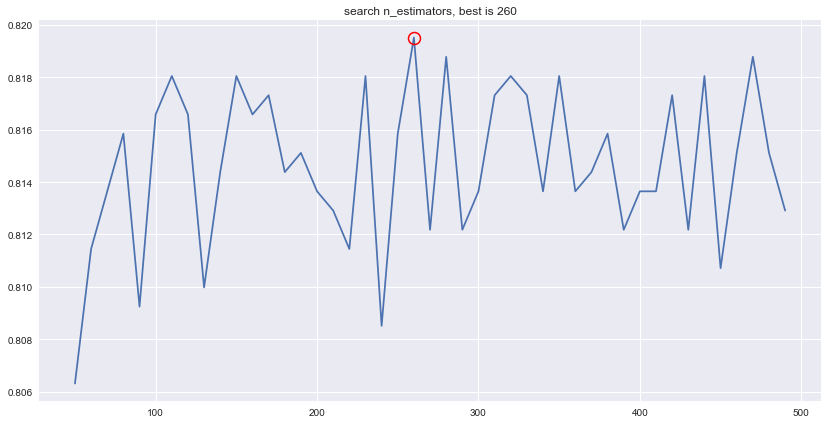

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=260, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
btc_ml.random_forest_classifier_best()

所有best函数中寻找最优参数内部只根据学习器的特点寻找最少量的参数设置，如果需要自定义参数范围可使用如下所示：

start grid search please wait...


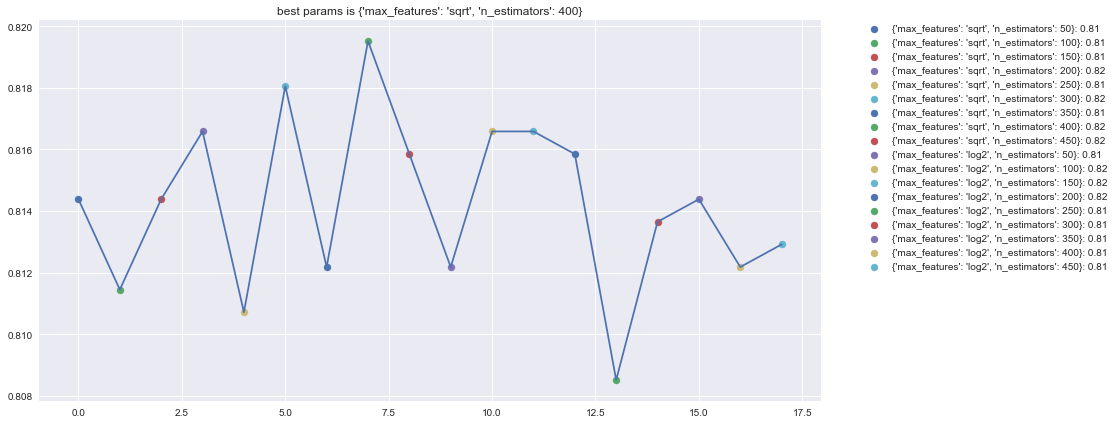

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
param_grid = {'max_features': ['sqrt', 'log2'], 'n_estimators': np.arange(50, 500, 50)}
btc_ml.random_forest_classifier_best(param_grid=param_grid)

下面使用btc_ml对训练集进行交叉准确率评分：

In [14]:
btc_ml.cross_val_accuracy_score()

RandomForestClassifier score mean: 0.8151620867325032


array([ 0.781 ,  0.8102,  0.7883,  0.8382,  0.8162,  0.8162,  0.8235,
        0.8456,  0.7794,  0.8529])

下面使用btc_ml对训练集进行交叉roc_auc评分：

In [15]:
btc_ml.cross_val_roc_auc_score()

RandomForestClassifier score mean: 0.8399573797130188


array([ 0.815 ,  0.8785,  0.8166,  0.8018,  0.8707,  0.8484,  0.8148,
        0.8551,  0.8005,  0.8981])

AbuML对外的函数都支持关键子参数fiter_type，可以指定使用的学习器类型如回归，聚类等，每个函数都通过内部装饰器声明自己支持的学习器类型对不支持的类型输出不支持，如下想通过指定使用回归器进行roc_auc评分：

In [16]:
btc_ml.cross_val_roc_auc_score(fiter_type=ml.EMLFitType.E_FIT_REG)

cross_val_roc_auc_score not support reg!


上述输出显示函数不支持回归器，因为内部实现中通过entry_wrapper装饰器声明了只支持E_FIT_CLF，即分类器：
    
    @entry_wrapper(support=(EMLFitType.E_FIT_CLF,))
    def cross_val_roc_auc_score(self, cv=10, **kwargs):
        """
        被装饰器entry_wrapper(support=(EMLFitType.E_FIT_CLF,))装饰，
        即支持有监督学习分类，使用cross_val_score对数据进行roc_auc度量，如果数据的y的
        label标签 > 2，通过label_binarize将label标签进行二值化处理，
        依次计算二值化的列的roc_auc，结果返回score最好的数据度量
        :param cv: 透传cross_val_score的参数，默认10
        :param kwargs: 外部可以传递x, y, 通过
                                x = kwargs.pop('x', self.x)
                                y = kwargs.pop('y', self.y)
                       确定传递self._do_cross_val_score中参数x，y，
                       以及装饰器使用的fiter_type，eg：
                       ttn_abu.cross_val_roc_auc_score(fiter_type=ml.EMLFitType.E_FIT_REG)
        :return: cross_val_score返回的score序列，
                 eg: array([ 1.  ,  0.9 ,  1.  ,  0.9 ,  1.  ,  0.9 ,  1.  ,  0.9 ,  0.95,  1.  ])
        """
        x = kwargs.pop('x', self.x)
        y = kwargs.pop('y', self.y)
        return self._do_cross_val_score(x, y, cv, _EMLScoreType.E_SCORE_ROC_AUC.value)

更多详情实现请阅读源代码AbuML

下面使用train_test_split_xy查看训练集输出的precision_score，recall_score，混淆矩阵，以及f1等度量结果：

In [17]:
btc_ml.train_test_split_xy()

x-y:(1363, 48)-(1363,)
train_x-train_y:(1226, 48)-(1226,)
test_x-test_y:(137, 48)-(137,)
accuracy = 0.77
precision_score = 0.62
recall_score = 0.39
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 |  90 |   9 |
Actual   |-----|-----|
       1 |  23 |  15 |
         |-----|-----|
             precision    recall  f1-score   support

        0.0       0.80      0.91      0.85        99
        1.0       0.62      0.39      0.48        38

avg / total       0.75      0.77      0.75       137



下面通过plot_roc_estimator绘制roc曲线：

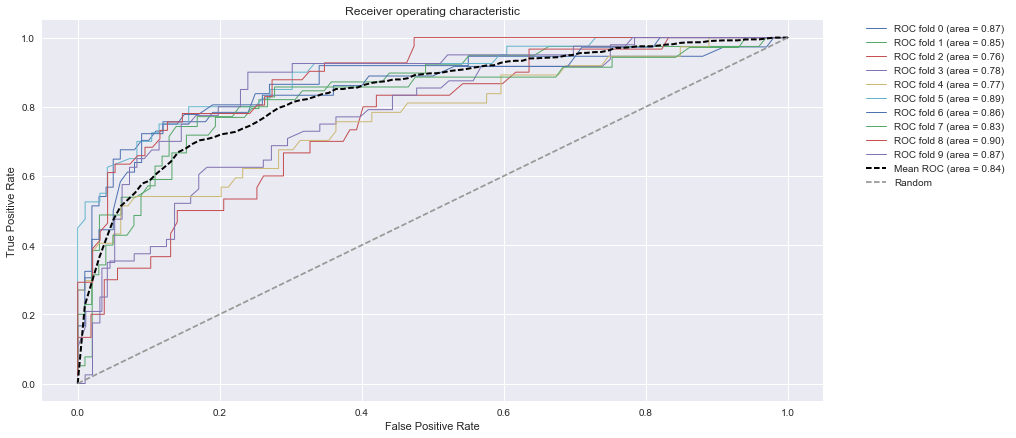

In [18]:
btc_ml.plot_roc_estimator()

下面通过plot_confusion_matrices绘制混淆矩阵：

[[915  65]
 [183 200]]


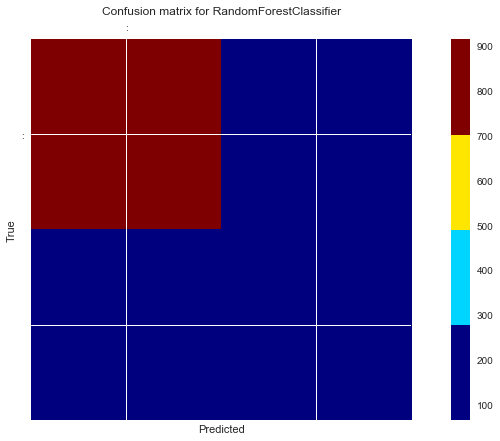

In [19]:
btc_ml.plot_confusion_matrices()

下面通过plot_decision_function绘制决策边界，由于绘制2d图，内部已经使用pca将数据特征降维后再绘制：

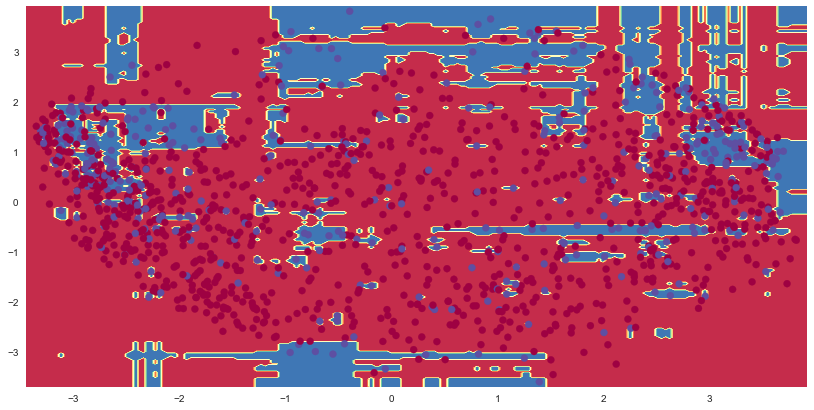

In [20]:
btc_ml.plot_decision_function()

下面通过plot_graphviz_tree绘制逻辑决策图：

RandomForestClassifier not hasattr tree_, use decision tree replace


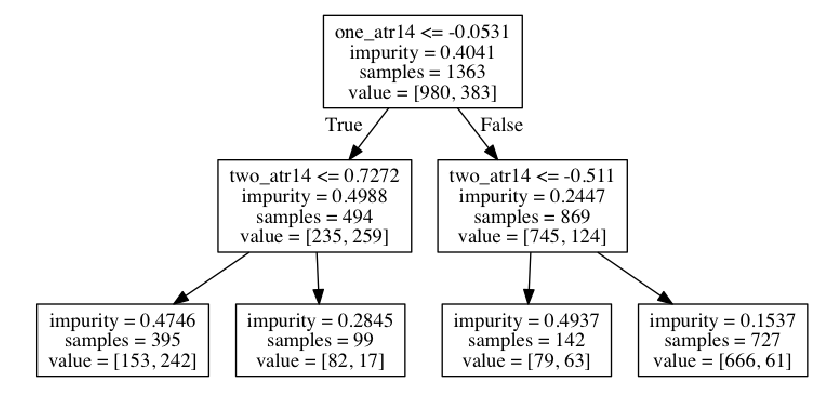

In [21]:
btc_ml.plot_graphviz_tree()

下面通过feature_selection对特征的支持度进行评级：

In [22]:
pd.options.display.max_rows = 48
btc_ml.feature_selection(show=False).sort_values(by='ranking')

,ranking,support
one_atr14,1,True
two_volume,1,True
two_open,1,True
two_ma5,1,True
two_ma21,1,True
two_ma10,1,True
two_low,1,True
two_high,1,True
two_close,1,True
two_atr21,1,True


下面通过importances_coef_pd对特征的重要程度进行量化：

In [23]:
btc_ml.importances_coef_pd().sort_values(by='importance')[::-1]

,feature,importance
1,one_atr21,0.1146
0,one_atr14,0.0819
16,two_atr21,0.0675
15,two_atr14,0.0562
11,one_volume,0.0357
18,two_high,0.0326
12,today_low,0.0325
2,one_close,0.0322
23,two_ma60,0.0314
26,two_volume,0.0311


### 3. 测试集的验证与非均衡技术

下面将前面保留切割的60条测试数据进行特征抽取组合，方式和抽取训练集时一样，代码如下所示：

In [24]:
btc_test0 = btc_siblings_df(btc_test_raw)
btc_test1 = btc_siblings_df(btc_test_raw[1:])
btc_test2 = btc_siblings_df(btc_test_raw[2:])
btc_test = pd.concat([btc_test0, btc_test1, btc_test2])
btc_test.index = np.arange(0, btc_test.shape[0])
dummies_one_week = pd.get_dummies(btc_test['one_date_week'], prefix='one_date_week')
dummies_two_week = pd.get_dummies(btc_test['two_date_week'], prefix='two_date_week')
dummies_today_week = pd.get_dummies(btc_test['today_date_week'], prefix='today_date_week')
btc_test.drop(['one_date_week', 'two_date_week', 'today_date_week'], inplace=True, axis=1)
btc_test = pd.concat([btc_test, dummies_one_week, dummies_two_week, dummies_today_week], axis=1)
matrix_test = btc_test.as_matrix()
y_test = matrix_test[:, 0]
x_test = matrix_test[:, 1:]

对测试集数据进行准确率评估，代码如下所示：

In [25]:
from sklearn import metrics
y_predict = [btc_ml.predict(x_test[test_ind])[0] for test_ind in np.arange(0, matrix_test.shape[0])]
print('测试集正确率{:3f}'.format(metrics.accuracy_score(y_test, y_predict)))

测试集正确率0.620690


如上所示上面的准确率结果为60%以上正确，下面使用predict_proba看看概率结果：

In [26]:
y_prob = [btc_ml.predict_proba(x_test[test_ind])[0] for test_ind in np.arange(0, matrix_test.shape[0])]

In [27]:
y_prob[-10:]

[array([ 0.495,  0.505]),
 array([ 0.9075,  0.0925]),
 array([ 0.7875,  0.2125]),
 array([ 0.83,  0.17]),
 array([ 0.8375,  0.1625]),
 array([ 0.96,  0.04]),
 array([ 0.58,  0.42]),
 array([ 0.495,  0.505]),
 array([ 0.6575,  0.3425]),
 array([ 0.565,  0.435])]

本节开始的时候说过很多时候定估的决策只要能满足有时候能解出合理的解就可以，通过非均衡技术对决策进行二次逻辑过滤即可，下面解释这句话的意思，通过上面y_predict输出你可以看到准确率结果为60%以上，如果你只按照这个决策认定比特币今天是否有大行情还是有很多错误的可能，上面的y_prob输出了每一个决策的概率。

那么我们如果希望做比特币交易只希望在决策模型有很大把握的情况下才做，否则宁可少赚点钱也不做应该怎么做呢？

上面predict的决策在某一个值在0.5以上即进行了判断，如果我们希望把握更大一些就需要调整这个值，比如0.55以上才能认定决策，那首要的问题就是如何选定这个阀值，下面示例使用search_match_pos_threshold进行阀值的确定：

In [28]:
btc_ml.search_match_pos_threshold(accuracy_match=0.85)

search pos threshold:threshold:0.57 accuracy:0.84, effect_rate:0.90:16.0%

0.580 satisfy require, accuracy:0.854, effect_rate:0.879


0.57999999999999996

结果如上所示，search_match_pos_threshold函数的作用是对训练集数据进行非均衡结果度量，从0.5至0.99的范围内开始不断向上调整决策阀值：

比如测试阀值为0.55，那么如果决策的概率为array([ 0.5378,  0.4622])，那么通过阀值二分化后结果为(0, 0)，这个结果将不计入正确率统计中，即认为未达成有效的决策，但如果决策的概率为 array([ 0.9711,  0.0289])，那么通过阀值二分化后结果为(1, 0)，认为达成有效的决策，当有效的决策正确率达到参数accuracy_match传递的值，本例中使用0.85即85%的正确率时，停止搜索，本例返回的结果为0.580，即使用阀值0.580可以达成非均衡决策的85%正确率。

备注：与之对应search_match_neg_threshold进行阀值搜索，从0.5至0.01的范围内开始不断向下调整决策阀值，更多详情请阅读源代码。

下面使用0.580做为阀值，通过predict_proba_threshold函数进行决策，代码如下：

In [29]:
y_prob_threshold = [btc_ml.predict_proba_threshold(x_test[test_ind], 0.580, 0)
                    for test_ind in np.arange(0, matrix_test.shape[0])]

上面predict_proba_threshold传递的第三个参数0为未达成有效决策的情况下返回的决策结果，即阀值二分化后结果为(0, 0)后这里返回0，因为在比特币这个示例中如果交易者想要保守的方式决策今天是否适合做日内交易，那么就希望只在有很大概率的情况下返回1，即适合交易，其它情况下没有太大把握下全部返回0即可，下面使用precision_score计算查准率：

In [30]:
metrics.precision_score(y_test, y_prob_threshold)

1.0

如上所示查准率100%正确，但召回率评分非常低，即比特币在很多有大行情的情况下为了保守，放弃了日交易，只在把握大的时候行动:

In [31]:
metrics.recall_score(y_test, y_prob_threshold)

0.20000000000000001

与上面的情况相反也有些激进的交易者想要的决策结果是只要今天不是很大把握说没有行情，那就进行交易。

下面使用0.90做为阀值，通过predict_proba_threshold函数进行决策，第三个参数1即在为未达成有效决策的情况下返回的决策结果为1，可以看到结果的决策中大多数都被决策为1，代码如下：

In [32]:
y_prob_threshold = [btc_ml.predict_proba_threshold(x_test[test_ind], 0.90, 1)
                    for test_ind in np.arange(0, matrix_test.shape[0])]
pd.Series(y_prob_threshold).value_counts()

1    49
0     9
dtype: int64

### 4. 继承AbuMLPd对数据处理进行封装

在abupy中不建议直接使用AbuML类进行构造，推荐使用继承AbuMLPd后实现make_xy方法，在make_xy中将数据训练集和测试集进行组装完成，AbuMLPd基类通过代理方法对AbuML中的所有方法进行代理，即可以和使用AbuML中的方法一样的接口操作，本节使用的示例内置在abupy项目中BtcBigWaveClf类，具体实现请直接阅读BtcBigWaveClf。

小结：由于abupy中内置沙盒数据没有分时的数据，所以本示例使用日线数据做为分析对象，实际策略中应该使用的是分钟数据，本节示例主要为配合abupy中机器学习模块的使用示例所写，与真实的日内交易决策还有很大差别，在后面的章节涉及到实盘交易章节会具体详细的示例完整的一个日内交易策略，请关注公众号的更新提醒。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)


abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)


[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)